### Time Series Forecasting

In [1]:
import json
import datetime
import numpy as np 
import pandas as pd 
import pmdarima as pm
import matplotlib.pyplot as plt 
from matplotlib import rcParams
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

plt.style.use('seaborn')
rcParams.update({'figure.autolayout': True})

%matplotlib inline


### Load Data

In [2]:
def preprocess_df(df):
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
    df.index = df['date']
    df.drop(['date', 'status'], inplace=True, axis=1)

    for col in df:
        df[col] = pd.to_numeric(df[col])


with open('data\\states_daily.json') as f:
    data = json.load(f)

confirmed_df = pd.DataFrame(data['confirmed'])
preprocess_df(confirmed_df)

total_confirmed_cases = confirmed_df['tt']
total_confirmed_cases_cum = confirmed_df['tt'].cumsum()

tn_confirmed_cases = confirmed_df['tn']
tn_confirmed_cases_cum = confirmed_df['tn'].cumsum()

print(f'Length of dataset (Number of days): {len(tn_confirmed_cases)}')

Length of dataset (Number of days): 48


### Rolling Average

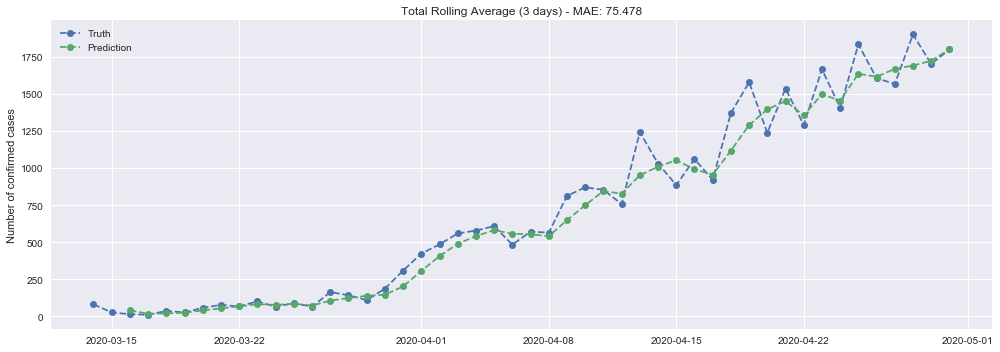

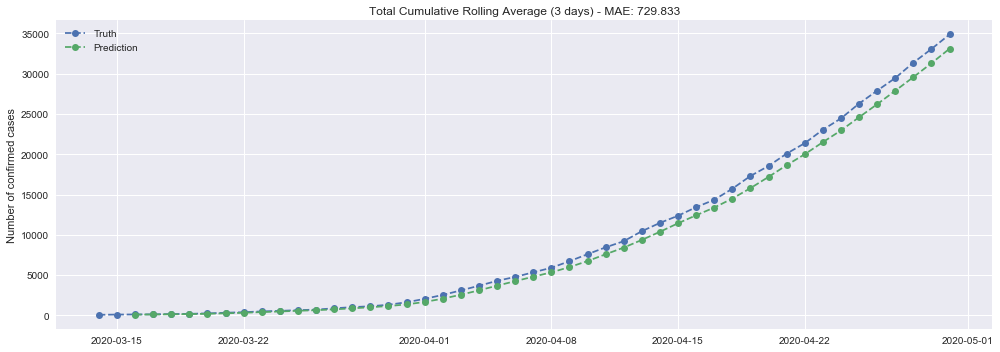

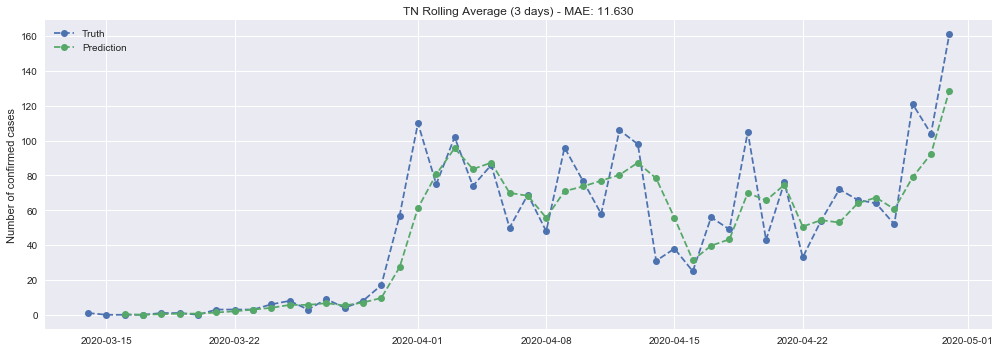

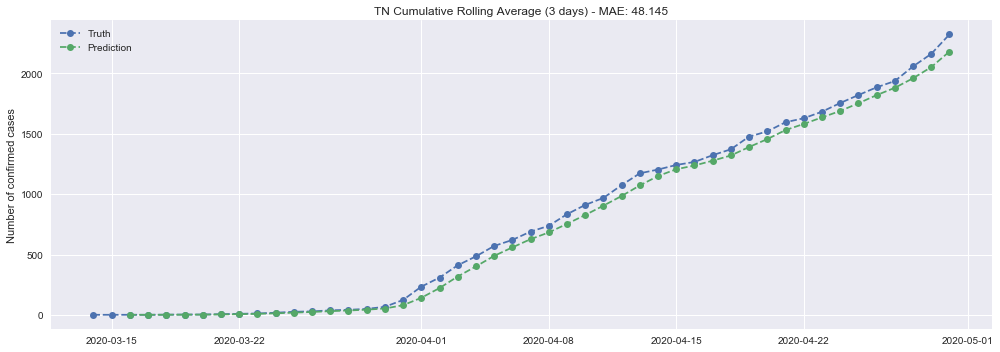

Type: Total, Value: 75.4782608695652
Type: Total Cumulative, Value: 729.8333333333333
Type: TN, Value: 11.630434782608695
Type: TN Cumulative, Value: 48.14492753623189


In [3]:
rolling_average_losses = {}

def plot_truth_pred_data(truth, pred, title=''):
    plt.figure(figsize=(14, 5))
    plt.plot(truth.index, truth.values, '--o', label='Truth')
    plt.plot(pred.index, pred.values, '--o', label='Prediction')
    plt.title(title)
    plt.ylabel('Number of confirmed cases')
    plt.legend()
    plt.show()


def calculate_rolling_avg_and_plot(df, name, window=3):
    pred = df.rolling(window=window).mean().dropna()
    mae = mean_absolute_error(df[:-window + 1], pred)
    rolling_average_losses[name] = mae
    plot_truth_pred_data(df, pred, title=f'{name} Rolling Average ({window} days) - MAE: {mae:.3f}')


calculate_rolling_avg_and_plot(total_confirmed_cases, name='Total')
calculate_rolling_avg_and_plot(total_confirmed_cases_cum, name='Total Cumulative')
calculate_rolling_avg_and_plot(tn_confirmed_cases, name='TN')
calculate_rolling_avg_and_plot(tn_confirmed_cases_cum, name='TN Cumulative')

for key, value in rolling_average_losses.items():
    print(f'Type: {key}, Value: {value}')

### Auto ARIMA

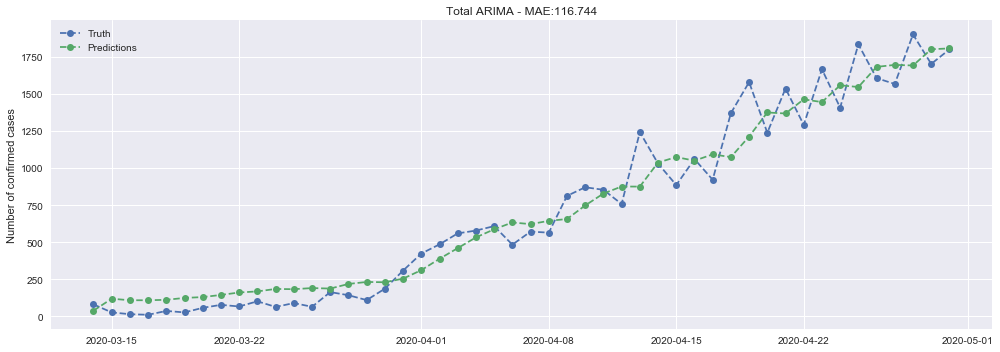

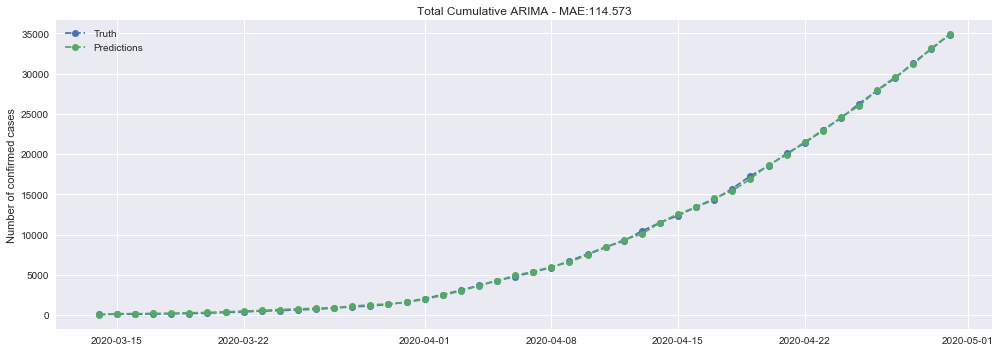

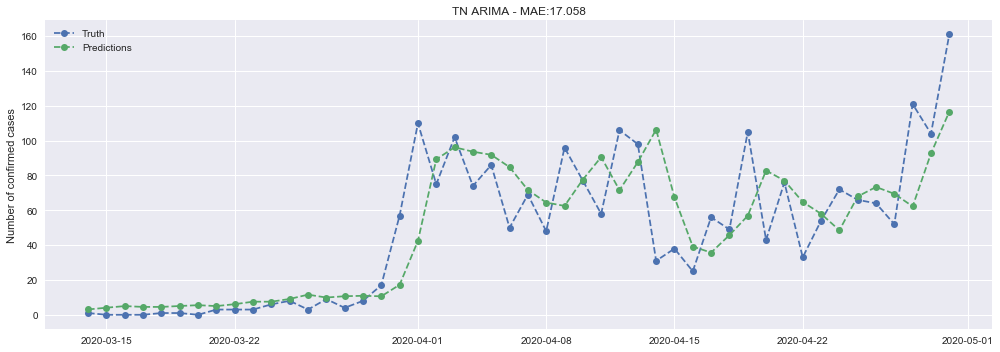

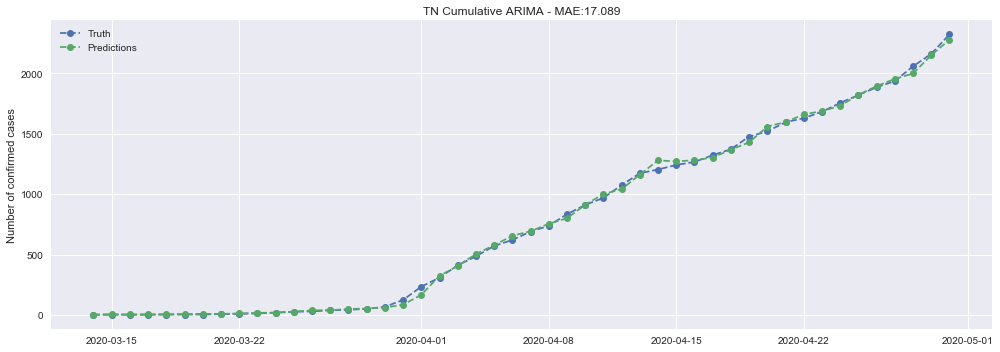

Type: Total, Loss: 116.7441602202701
Type: Total Cumulative, Loss: 114.5729756288257
Type: TN, Loss: 17.05846227089567
Type: TN Cumulative, Loss: 17.089073839734674


In [4]:
arima_losses = {}

def train_auto_arima_and_plot(series, title=''):

    arima_model = pm.auto_arima(series,
                                trace=False,
                                suppress_warnings=True,
                                error_action='ignore')

    preds = arima_model.predict_in_sample()
 
    mae = mean_absolute_error(series, preds)

    arima_losses[title] = mae

    plt.figure(figsize=(14, 5))
    plt.plot(series.index, series.values, '--o', label='Truth')
    plt.plot(series.index, preds, '--o', label='Predictions')
    plt.legend()
    plt.ylabel('Number of confirmed cases')
    plt.title(f'{title} ARIMA - MAE:{mae:.3f}')
    plt.show()
    plt.close()

train_auto_arima_and_plot(total_confirmed_cases, title='Total')
train_auto_arima_and_plot(total_confirmed_cases_cum, title='Total Cumulative')
train_auto_arima_and_plot(tn_confirmed_cases, title='TN')
train_auto_arima_and_plot(tn_confirmed_cases_cum, title='TN Cumulative')

for key, value in arima_losses.items():
    print(f'Type: {key}, Loss: {value}')

### Comparing Rolling Average and ARIMA

In [5]:
for key, value in arima_losses.items():
    print(f'Type: {key}, Rolling Average MAE: {rolling_average_losses[key]:.3f}, ARIMA MAE: {value:.3f}')


Type: Total, Rolling Average MAE: 75.478, ARIMA MAE: 116.744
Type: Total Cumulative, Rolling Average MAE: 729.833, ARIMA MAE: 114.573
Type: TN, Rolling Average MAE: 11.630, ARIMA MAE: 17.058
Type: TN Cumulative, Rolling Average MAE: 48.145, ARIMA MAE: 17.089


### Test Auto ARIMA

In [6]:
def get_number_of_confirmed_cases_tmr(series, title='', future_days=3):

    arima_model = pm.auto_arima(series,
                                trace=False,
                                suppress_warnings=True,
                                error_action='ignore')
    
    predictions = arima_model.predict(n_periods=future_days)
    dates = [series.index[-1] + datetime.timedelta(days=i) for i in range(1, future_days + 1)]

    print(f'\nType of Prediction: {title}')

    for i in range(future_days):
        print(f"Date: {dates[i].strftime('%Y-%m-%d')} Prediction: {round(predictions[i])}")


get_number_of_confirmed_cases_tmr(total_confirmed_cases, title='Total Confirmed Cases')
get_number_of_confirmed_cases_tmr(total_confirmed_cases_cum, title='Total Confirmed Cases Cumulative')
get_number_of_confirmed_cases_tmr(tn_confirmed_cases, title='TN Confirmed Cases')
get_number_of_confirmed_cases_tmr(tn_confirmed_cases_cum, title='TN Confirmed Cases Cumulative')


Type of Prediction: Total Confirmed Cases
Date: 2020-05-01 Prediction: 1844.0
Date: 2020-05-02 Prediction: 1884.0
Date: 2020-05-03 Prediction: 1923.0

Type of Prediction: Total Confirmed Cases Cumulative
Date: 2020-05-01 Prediction: 36712.0
Date: 2020-05-02 Prediction: 38601.0
Date: 2020-05-03 Prediction: 40532.0

Type of Prediction: TN Confirmed Cases
Date: 2020-05-01 Prediction: 138.0
Date: 2020-05-02 Prediction: 154.0
Date: 2020-05-03 Prediction: 151.0

Type of Prediction: TN Confirmed Cases Cumulative
Date: 2020-05-01 Prediction: 2461.0
Date: 2020-05-02 Prediction: 2615.0
Date: 2020-05-03 Prediction: 2766.0
